## Image Caption Generation (ICG) using PyTorch

This project uses a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) [<a href="#ref1">1</a>] for image caption generation. The subset consists of 5029 of these images, each of which has five or more different descriptions of the salient entities and activities.

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torchvision.models import ResNet152_Weights
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter, defaultdict
import random
import os
import json
import re

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
#!nvidia-smi

In [5]:
# +---------------------------------------------------------------------------------------+
# | NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
# |-----------------------------------------+----------------------+----------------------+
# | GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
# | Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
# |                                         |                      |               MIG M. |
# |=========================================+======================+======================|
# |   0  NVIDIA GeForce RTX 3060 Ti     Off | 00000000:02:00.0  On |                  N/A |
# | 34%   35C    P0              38W / 200W |    573MiB /  8192MiB |      2%      Default |
# |                                         |                      |                  N/A |
# +-----------------------------------------+----------------------+----------------------+

Hardware Overview

In [6]:
#!neofetch

In [7]:
# Host: 90Q800C9SZ Legion T7 34IMZ5 
# Kernel: 6.8.0-49-generic 
# CPU: 11th Gen Intel i7-11700KF (16) @ 4.900GHz 
# GPU: NVIDIA GeForce RTX 3060 Ti 
# Memory: 7726MiB / 31833MiB

## 0. Exploratory Data Analysis (EDA)

In [8]:
from PIL import Image

def display_sample_images(df, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        image_id = df.iloc[i]['id']
        image_filename = df.iloc[i]['file_name']
        image_path = os.path.join('images', image_filename)

        try:
            image = Image.open(image_path).convert('RGB')
            plt.imshow(image)
            plt.title(f"ID: {image_id}\nSize: {df.iloc[i]['height']}x{df.iloc[i]['width']}")
            plt.axis('off')
        except Exception as e:
            print(f"Exception loading image {image_path}: {e}")

    plt.show()

In [ ]:
meta_data_path = 'datasets/coco/images/metadata/coco_subset_meta.csv'
images_dir = 'datasets/coco/images/' # must extract datasets/coco/images/coco_subset_images.zip
annotations_path = 'datasets/coco/annotations/instances_train2017.json' # must extract datasets/coco/annotations/annotations_trainval2017.zip
captions_path = 'datasets/coco/annotations/captions_train2017.json'


meta_df = pd.read_csv(meta_data_path, index_col=0)
print(f"Loaded meta data with {len(meta_df)} entries.")


with open(annotations_path, 'r') as f:
    annotations = json.load(f)
print(f"Loaded annotations.")

print(meta_df.head(5))
print(meta_df.dtypes)
print(meta_df.isnull().sum())

Loaded meta data with 8000 entries.
Loaded annotations.
   license         file_name  \
0        2  000000262145.jpg   
1        1  000000262146.jpg   
2        3  000000524291.jpg   
3        1  000000262148.jpg   
4        3  000000393223.jpg   

                                            coco_url  height  width  \
0  http://images.cocodataset.org/train2017/000000...     427    640   
1  http://images.cocodataset.org/train2017/000000...     640    480   
2  http://images.cocodataset.org/train2017/000000...     426    640   
3  http://images.cocodataset.org/train2017/000000...     512    640   
4  http://images.cocodataset.org/train2017/000000...     480    640   

         date_captured                                         flickr_url  \
0  2013-11-20 02:07:55  http://farm8.staticflickr.com/7187/6967031859_...   
1  2013-11-19 23:07:16  http://farm6.staticflickr.com/5090/5341741494_...   
2  2013-11-18 09:59:07  http://farm2.staticflickr.com/1045/934293170_d...   
3  2013-11-20 05

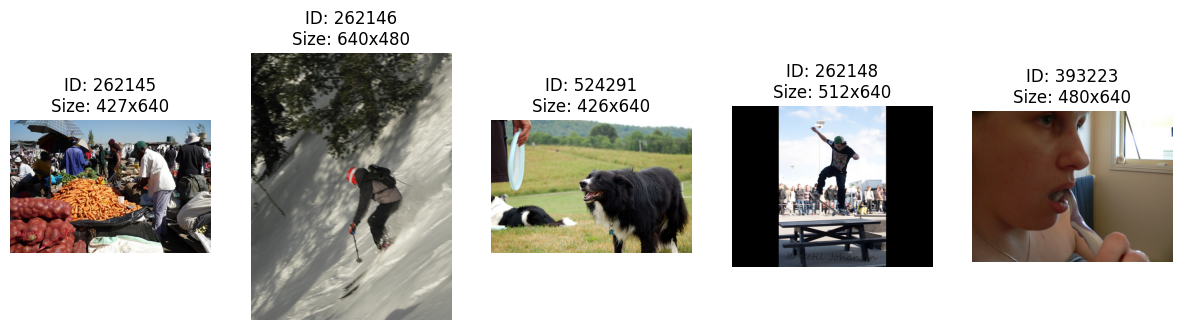

In [10]:
display_sample_images(meta_df, num_samples=5)

### Handle duplicates

In [ ]:
# check for duplicates image IDs
duplicate_ids = meta_df['id'].duplicated().sum()
print(f"Number of duplicate image IDs: {duplicate_ids}")

duplicates = meta_df[meta_df.duplicated(subset=['id'], keep=False)]
print(duplicates.head(10))

Number of duplicate image IDs: 2971
    license         file_name  \
0         2  000000262145.jpg   
1         1  000000262146.jpg   
2         3  000000524291.jpg   
3         1  000000262148.jpg   
4         3  000000393223.jpg   
5         2  000000393224.jpg   
6         7  000000524297.jpg   
7         4  000000393227.jpg   
9         6  000000393230.jpg   
10        4  000000262161.jpg   

                                             coco_url  height  width  \
0   http://images.cocodataset.org/train2017/000000...     427    640   
1   http://images.cocodataset.org/train2017/000000...     640    480   
2   http://images.cocodataset.org/train2017/000000...     426    640   
3   http://images.cocodataset.org/train2017/000000...     512    640   
4   http://images.cocodataset.org/train2017/000000...     480    640   
5   http://images.cocodataset.org/train2017/000000...     640    427   
6   http://images.cocodataset.org/train2017/000000...     446    640   
7   http://images.cocoda

In [12]:
# deduplicate by keeping the first occurrence
if duplicate_ids > 0:
    meta_df = meta_df.drop_duplicates(subset=['id'], keep='first').reset_index(drop=True)
    print(f"Entries after removing duplicate image IDs: {len(meta_df)}")

Entries after removing duplicate image IDs: 5029


`meta_df` now matches the subset consisting of 5029 of these images with at five textual reference captions per image, as we will confirm in section 2.2.  

_The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last fully-connected layer of a pre-trained CNN. This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects._


    ┌───────────────────────────────────────────────────────────────────┐
    │                           (Pretrained ResNet152                   │
    │                            on ImageNet dataset)                   │
    │                                                                   │
    │         ┌───────────────────────────────────────────────────┐     │
    │         │                   EncoderCNN                      │     │
    │         │    (extracts 1×2048 feature vector from fc)       │     │
    │         └───────────────────────────────────────────────────┘     │
    │            ▲                                             ▲        │
    │            │       Feature vector at fc (1×2048)         │        │
    └────────────┼─────────────────────────────────────────────┼──────  ┘
                 │                   save to disk              │
                 ▼                                             │
     ┌─────────────────┐                                       │
     │   Input Image   │                                       │
     │ (224×224×3)     │                                       │
     └─────────────────┘                                       │
                                                               │
                                                               ▼
                                                   ┌────────────────────┐
                                                   │ Linear + BatchNorm │
                                                   └────────────────────┘
                                                               │
                                                               ▼
                                                  ┌─────────────────────┐
                                                  │     DecoderRNN      │
                                                  └─────────────────────┘
                                                           │
                         ┌─────────────────────────┬───────┴───────────────────────┬───────────────────────┐
                         │ Word embedding (W_emb) │         Word embedding (W_emb) │         Word embedding (W_emb) │
                         ▼                        ▼                                ▼                                ▼
                   ┌─────────┐             ┌─────────┐                       ┌─────────┐                      ┌─────────┐
        "a"  --->  │   RNN   │     "man" → │   RNN   │             "standing"│   RNN   │            "lake" →  │   RNN   │
                   └─────────┘             └─────────┘                       └─────────┘                      └─────────┘
                         │                       │                                  │                               │
                         ▼                       ▼                                  ▼                               ▼
                       ...                     ...                                ...                             <end>

Figure 1. Overview diagram of our image-to-text model using ResNet-152, where an Encoder network encodes the input image as a feature vector
(we use [ResNet-152](https://arxiv.org/abs/1512.03385)). 

### Organisation of the Notebook

> 0. Exploratory Data Analysis (EDA) [Added]
> 1. Extracting image features [4 marks]
> 2. Text preparation of training and validation data [10 marks]
> 3. Training the decoder [28 marks]
> 4. Generating predictions on test data [8 marks]
> 5. Caption evaluation via BLEU score [10 marks]
> 6. Caption evaluation via Cosine similarity [17 makrs]
> 7. Comparing BLEU and Cosine similarity [20 marks]
> 8. Overall quality [3 marks]

## 1 Extracting image features 

### 1.1 EncoderCNN

In [13]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load pretrained CNN and remove the topmost fc layer."""
        super(EncoderCNN, self).__init__()
        
        # 1. Load the ResNet-152 pretrained model 
        # using the 'weights' parameter due to warnings received
        # DEFAULT == ResNet152_Weights.IMAGENET1K_V2
        # source: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet152.html#torchvision.models.ResNet152_Weights
        weights = ResNet152_Weights.DEFAULT  
        resnet = models.resnet152(weights=weights)
        
        # 2. Keep all layers except the final classification layer.
        modules = list(resnet.children())[:-1]   # removes the last layer (FC)
        self.resnet = nn.Sequential(*modules)

    def forward(self, images):
        """Extract feature vectors from input images."""
        
        # 1. Disable gradients for the forward pass through the CNN.
        with torch.no_grad():
            # 2. Pass the images through the modified network.
            features = self.resnet(images)
            
        # 3. Reshape the features to (batch_size, feature_dim)
        features = features.view(features.size(0), -1)
        return features

In [14]:
# instantiate encoder and put into evaluation mode.
encoder = EncoderCNN().to(device)
encoder.eval()

EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

### 1.2 Processing the images

In [ ]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms: mean, std
                         (0.229, 0.224, 0.225))]) 

In [15]:
class CocoDataset(Dataset):
    def __init__(self, meta_df, images_dir, transform=None):
        """
            meta_df: DataFrame containing image metadata.
            images_dir: Directory where images are stored.
            transform: Optional transform to be applied on an image.
        """
        self.meta_df = meta_df
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.meta_df)

    def __getitem__(self, idx):
        image_id = self.meta_df.iloc[idx]['id']
        file_name = self.meta_df.iloc[idx]['file_name']
        image_path = os.path.join(self.images_dir, file_name)
        
        # load images...
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
        
        if self.transform:
            image = self.transform(image)
        
        return image
        # return image_id, image

In [ ]:
dataset = CocoDataset(meta_df=meta_df, images_dir=images_dir, transform=data_transform)

# Define DataLoader and its parameters
# setting for my local NVIDIA GeForce RTX 3060 Ti with 8 GB
batch_size = 64  # adjusted based on available GPU
num_workers = 4  # adjusted based on CPU cores

# loads data in batches
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [18]:
all_features = []

for batch in data_loader:
    images = batch.to(device)  # batch is a Tensor
    with torch.no_grad():
        features = encoder(images)  # (batch_size, 2048)
    all_features.append(features.cpu())

# cat features into a single Tensor
all_features = torch.cat(all_features, dim=0)  # feature vectors with shape (num_images, 2048)
print(f"Extracted features for {all_features.size(0)} images.")

Extracted features for 5029 images.


In [19]:
features_path = 'features.pt'
torch.save(all_features, features_path)

In [ ]:
# load the saved features above
img_features = torch.load(features_path)
print(f"Number of features: {len(img_features)}")
print(f"Types : {type(img_features)}")
print(f"Shape of features: {img_features.shape}")  # torch.Size([5029, 2048])

Number of features: 5029
Types : <class 'torch.Tensor'>
Shape of features: torch.Size([5029, 2048])


/tmp/ipykernel_14542/2007056100.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_features = torch.load(features_path)


In [ ]:
sample_feature = img_features[0] # sample just the first 
print(f"Sample Feature Shape: {sample_feature.shape}")
print(f"Sample Feature Tensor: {sample_feature}")

Sample Feature Shape: torch.Size([2048])
Sample Feature Tensor: tensor([0.0000, 0.0000, 0.0060,  ..., 0.0000, 0.0042, 0.0574])


## 2 Text preparation 


### 2.1 Build the caption dataset

_All selected COCO_5029 images are from the official 2017 train set._

In [23]:
# meta_df was prepared in the EDA section
print(meta_df.head())

   license         file_name  \
0        2  000000262145.jpg   
1        1  000000262146.jpg   
2        3  000000524291.jpg   
3        1  000000262148.jpg   
4        3  000000393223.jpg   

                                            coco_url  height  width  \
0  http://images.cocodataset.org/train2017/000000...     427    640   
1  http://images.cocodataset.org/train2017/000000...     640    480   
2  http://images.cocodataset.org/train2017/000000...     426    640   
3  http://images.cocodataset.org/train2017/000000...     512    640   
4  http://images.cocodataset.org/train2017/000000...     480    640   

         date_captured                                         flickr_url  \
0  2013-11-20 02:07:55  http://farm8.staticflickr.com/7187/6967031859_...   
1  2013-11-19 23:07:16  http://farm6.staticflickr.com/5090/5341741494_...   
2  2013-11-18 09:59:07  http://farm2.staticflickr.com/1045/934293170_d...   
3  2013-11-20 05:50:03  http://farm5.staticflickr.com/4028/4549977479_..

In [24]:
# load the captions using the path defined in the EDA section
# captions_path = 'annotations/captions_train2017.json'
with open(captions_path, 'r') as f:
    captions_data = json.load(f)

print(captions_data.keys())

dict_keys(['info', 'licenses', 'images', 'annotations'])


In [25]:
# meta_df['id'] contains all unique image IDs for the subset
subset_image_ids = set(meta_df['id'].tolist())

# map image IDs to their captions
image_id_to_captions = defaultdict(list)

# map image IDs to their captions
for annotation in captions_data['annotations']:
    image_id = annotation['image_id']
    caption = annotation['caption']
    if image_id in subset_image_ids:
        image_id_to_captions[image_id].append(caption)

print(f"Number of images with captions: {len(image_id_to_captions)}")
#print(image_id_to_captions) # commented out due to output being to large

Number of images with captions: 5029

Map each image ID in the COCO subset to all of its corresponding reference captions.  

meta_df contains COCO_5029 data, and each row corresponds to one image and includes columns such as id, file_name, coco_url, height, width, etc.  

The `image_id_to_captions` dictionary looks like this (formatted for readability):  
```
`defaultdict(<class 'list'>,  

{57429: ['An airplane with its landing wheels out landing. ', 'A plane that is taking off at an airport', 'A man takes a picture of an airplane taking off.', 'A large jet takes off from an airport runway.', 'The airplane is taking off on the runway at the airport.'],  
410627: ['The young man is stirring his pot of food with a wooden spoon.', 'A man enjoys cooking food in a pan', 'A smiling man is cooking in his kitchen.', 'A man smiles as he stirs his food in the pot.', 'A boy smiles while holding a pot and spoon.'],  
554037: ['a counter with vegetables, knife and cutting board on it. ', 'asparragus, lemons and a bowl of rice on a counter top', 'The preparation of salmon, asparagus and lemons. ', 'Cooking table with assorted fish and lemons with asparagus. ', 'A kitchen counter with cutting board, knife and food.'], ...`  
``` 

### 2.2 Clean the captions

_Create a cleaned version of each caption._


In [26]:
def clean_caption(caption):
    """
    cleans the input caption by converting it to lowercase and removing non-alphabet characters.
    """
    caption = caption.lower()
    
    # rm non-alphabetic chars, retain spaces
    caption = re.sub(r'[^a-z\s]', '', caption)
    
    # strip spaces
    caption = re.sub(r'\s+', ' ', caption).strip()
    
    return caption

#### Create caption_df 

In [ ]:
image_ids, file_names, captions = []

for idx, row in meta_df.iterrows():
    image_id = row['id']
    file_name = row['file_name']
    image_captions = image_id_to_captions.get(image_id, [])
    
    # each image should have at least one caption
    if len(image_captions) == 0:
        print(f"No captions found for image ID {image_id}")
    
    # create separate entries
    # for images with multiple captions
    for caption in image_captions:
        image_ids.append(image_id)
        file_names.append(file_name)
        captions.append(caption)

# create the DataFrame
caption_df = pd.DataFrame({
    'id': image_ids,
    'file_name': file_names,
    'caption': captions
})

Using the `image_id_to_captions` dict, this code block retrieves all captions for each image in meta_df. For each image, it appends (image_id, file_name, caption) to corresponding lists. This ensures that each row in the final caption_df dataframe corresponds to a single (image, caption) tuple/pair. 

In [28]:
# clean captions is assigned into a new 'caption' column
caption_df['cleaned_caption'] = caption_df['caption'].apply(clean_caption)

After creating the caption_df, we apply `clean_caption()` to every raw caption, creating a separate cleaned_caption column. We now ensure the dataset of captions is ready for tokenization and building the vocabulary.  

In [ ]:
# the number of captions per image
caption_counts = caption_df.groupby('id').size()
print(caption_counts)

id
9         5
25        5
30        5
34        5
36        5
         ..
581906    5
581909    5
581913    5
581921    5
581929    5
Length: 5029, dtype: int64


In [30]:
# Print out 10 original captions next to their cleaned versions
print("\nCaption dataFrame:")
print(caption_df.head(10))


Caption DataFrame:
       id         file_name  \
0  262145  000000262145.jpg   
1  262145  000000262145.jpg   
2  262145  000000262145.jpg   
3  262145  000000262145.jpg   
4  262145  000000262145.jpg   
5  262146  000000262146.jpg   
6  262146  000000262146.jpg   
7  262146  000000262146.jpg   
8  262146  000000262146.jpg   
9  262146  000000262146.jpg   

                                             caption  \
0  People shopping in an open market for vegetables.   
1  An open market full of people and piles of veg...   
2  People are shopping at an open air produce mar...   
3  Large piles of carrots and potatoes at a crowd...   
4  People shop for vegetables like carrots and po...   
5                 a person skiing down a steep hill    
6           A person skiing down a steep snowy hill.   
7    A person on snow skis going down a steep slope.   
8         A skier is skiing down a down hill slope.    
9     A skier is shown taking on a very steep slope.   

                     

### 2.3  Split the data

_Split the data 70/10/20% into train/validation/test sets._

In [ ]:
def split_ids(image_id_list, train=0.7, valid=0.1, test=0.2, seed=13):
    """
        image_id_list: List of unique image IDs.
        train: Proportion of the dataset to allocate for training.
        valid: Proportion of the dataset to allocate for validation.
        test: Proportion of the dataset to allocate for testing.
    returns
        tuple: Three lists containing IDs for the training, validation, and test sets.
    """
    #  
    # 1. Calculate the number of items in each split (train, valid, test).
    total = train + valid + test
    if not (0.99 <= total <= 1.01):
        print(f"Warning: The sum of train, valid, and test proportions is {total}, which is not equal to 1.")
        # normalize 
        train = train / total
        valid = valid / total
        test = test / total
        print(f"Normalized proportions -> Train: {train:.4f}, Valid: {valid:.4f}, Test: {test:.4f}")

    # 2. Use list slicing to create the splits.
    # Think: How might you ensure the sets are representative of the overall dataset?
    # 2.1 Shuffle the image IDs to ensure random distribution
    random.seed(seed)
    shuffled_ids = image_id_list.copy()
    random.shuffle(shuffled_ids)

    # 2.2 split sizes
    n_total = len(shuffled_ids)
    n_train = int(n_total * train)
    n_valid = int(n_total * valid)
    n_test = n_total - n_train - n_valid

    # slice the shuffled data to create splits
    train_ids = shuffled_ids[:n_train]
    valid_ids = shuffled_ids[n_train:n_train + n_valid]
    test_ids = shuffled_ids[n_train + n_valid:n_train + n_valid + n_test]

    print(f"Total images: {n_total}")
    print(f"Training set: {len(train_ids)} images ({(len(train_ids)/n_total)*100:.2f}%)")
    print(f"Validation set: {len(valid_ids)} images ({(len(valid_ids)/n_total)*100:.2f}%)")
    print(f"Test set: {len(test_ids)} images ({(len(test_ids)/n_total)*100:.2f}%)")

    return train_ids, valid_ids, test_ids

This code splits the data into 70% training, 10% validation, and 20% test sets at the image level, and ensures that all captions related to any given image appear in only one subset, because it splits the image IDs rather than the individual captions.  In terms of proportions, we normalize them so that their sum becomes 1. Shuffling the list of image IDs before slicing ensures a random distribution of images across the training, validation and test sets.  

In [ ]:
unique_img_ids = caption_df['id'].unique().tolist()

train_ids, valid_ids, test_ids = split_ids(unique_img_ids, train=0.7, valid=0.1, test=0.2, seed=42)

print(f"\nTraining set size: {len(train_ids)}")
print(f"Validation set size: {len(valid_ids)}")
print(f"Test set size: {len(test_ids)}")

# check overlapping IDs between splits
overlap_train_valid = set(train_ids).intersection(set(valid_ids))
overlap_train_test = set(train_ids).intersection(set(test_ids))
overlap_valid_test = set(valid_ids).intersection(set(test_ids))

print(f"\nOverlap between Train and Valid sets: {len(overlap_train_valid)}")
print(f"Overlap between Train and Test sets: {len(overlap_train_test)}")
print(f"Overlap between Valid and Test sets: {len(overlap_valid_test)}")

# map splits to the DataFrame
split_mapping = {}
for img_id in train_ids:
    split_mapping[img_id] = 'train'
for img_id in valid_ids:
    split_mapping[img_id] = 'valid'
for img_id in test_ids:
    split_mapping[img_id] = 'test'

# add the 'split' column
caption_df['split'] = caption_df['id'].map(split_mapping)

# verify distribution
print("\nSplit Distribution:")
print(caption_df['split'].value_counts())

Total Images: 5029
Training Set: 3520 images (69.99%)
Validation Set: 502 images (9.98%)
Test Set: 1007 images (20.02%)

Training Set Size: 3520
Validation Set Size: 502
Test Set Size: 1007

Overlap between Train and Valid sets: 0
Overlap between Train and Test sets: 0
Overlap between Valid and Test sets: 0

Split Distribution:
split
train    17603
test      5038
valid     2513
Name: count, dtype: int64


The line `unique_img_ids = caption_df['id'].unique().tolist()` extracts the unique set of image IDs from caption_df dataFrame. Since caption_df has multiple captions per image, extracting unique IDs ensures we are working at the image-level. In other words, one image ID corresponds to one image.  
A split_mapping dictionary is created to map each image ID to its assigned split and afterwards the map() function creates a 'split' column in caption_df so every row (caption) is tagged with the corresponding set - train, valid, or test.  

### 2.4 Building the vocabulary

_The `Vocabulary` class provided below serves as a simple wrapper to map unique words to integer IDs._


In [33]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

        # debug
        #self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2, '<start>': 3}
        #self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>', 3: '<start>'}
        #self.idx = 3


    # 
    # Implement the logic to add a word to the vocabulary
    def add_word(self, w):
        if w not in self.word2idx:
            # assign
            self.word2idx[w] = self.idx
            # map  cur idx back to the word
            self.idx2word[self.idx] = w
            # process next new word
            self.idx += 1

    # 
    # Implement logic to retrieve the integer ID for a word
    # Return <unk>'s ID if the word is not found
    def __call__(self, word):
        return self.word2idx.get(word, self.word2idx['<unk>'])

    def __len__(self):
        return len(self.word2idx)

The Vocabulary class implements functionality as per instructions. 

_Collect all words from the cleaned captions in the **training and validation sets**, ignoring any words which appear 3 times or less_

In [34]:
train_valid_df = caption_df[caption_df['split'].isin(['train', 'valid'])]
print(train_valid_df['split'].value_counts())

split
train    17603
valid     2513
Name: count, dtype: int64


In [ ]:
# tokenize each caption into individual words 
# count the frequency of each word across train / val splits
word_freq = Counter()

for caption in train_valid_df['cleaned_caption']:
    tokens = caption.split()  # Tokenize by splitting on spaces
    word_freq.update(tokens)

print(f"Unique words before filter: {len(word_freq)}")

Unique words before filter: 6513


In [36]:
freq_threshold = 3

# filter words that appear more than freq_threshold
filtered_words = [word for word, freq in word_freq.items() if freq > freq_threshold]

print(f"Total Unique Words After Filtering (freq > {freq_threshold}): {len(filtered_words)}")

Total Unique Words After Filtering (freq > 3): 2401


In [37]:
vocab = Vocabulary()

# add filtered words to vocabulary
for word in filtered_words:
    vocab.add_word(word)

print(f"Vocabulary Size (Including Special Tokens): {len(vocab)}")

Vocabulary Size (Including Special Tokens): 2405


#### Vocabulary stats

In [38]:
print(f"\nFinal Vocabulary Size: {len(vocab)} words")

sample_words = ['a', 'cat', 'dog', 'the', 'on', 'windowsill', 'looking']
print("\nSample Word to ID Mappings:")
for word in sample_words:
    print(f"Word: '{word}' --> ID: {vocab(word)}")

sample_ids = [0, 1, 2, 3, 4, 5, 6]
print("\nSample ID to Word Mappings:")
for idx in sample_ids:
    print(f"ID: {idx} --> Word: '{vocab.idx2word[idx]}'")



Final Vocabulary Size: 2405 words

Sample Word to ID Mappings:
Word: 'a' --> ID: 22
Word: 'cat' --> ID: 541
Word: 'dog' --> ID: 46
Word: 'the' --> ID: 43
Word: 'on' --> ID: 33
Word: 'windowsill' --> ID: 1
Word: 'looking' --> ID: 51

Sample ID to Word Mappings:
ID: 0 --> Word: '<pad>'
ID: 1 --> Word: '<unk>'
ID: 2 --> Word: '<end>'
ID: 3 --> Word: 'people'
ID: 4 --> Word: 'shopping'
ID: 5 --> Word: 'in'
ID: 6 --> Word: 'an'


In [39]:
sample_row = caption_df.sample(2).iloc[0]
original_caption = sample_row['caption']
cleaned_caption = sample_row['cleaned_caption'].split()

print("Original caption:", original_caption)
print("Clean & Tokenized:", cleaned_caption)

Original caption: A cat that is laying down on a cushion. 
Clean & Tokenized: ['a', 'cat', 'that', 'is', 'laying', 'down', 'on', 'a', 'cushion']


In [ ]:
sample_row = caption_df.sample(2).iloc[0]
original_caption = sample_row['caption']
cleaned_caption = sample_row['cleaned_caption'].split()

print("Original caption:", original_caption)
print("Clean & Tokenized:", cleaned_caption)

Original caption: a cell phone sitting on a laptop in front of a television
Clean & Tokenized: ['a', 'cell', 'phone', 'sitting', 'on', 'a', 'laptop', 'in', 'front', 'of', 'a', 'television']


### 2.5 The Dataset and DataLoader


In [ ]:
def numericalize_caption(caption, vocab):
    """
    Converts a textual caption into a list of word IDs.
    """
    tokens = caption.strip().split()
    
    # convert words to corresponding IDs
    numericalized = [vocab(word) for word in tokens]
    
    return numericalized

In [42]:
caption_df['numericalized_caption'] = caption_df['cleaned_caption'].apply(lambda x: numericalize_caption(x, vocab))
print(caption_df[['caption', 'numericalized_caption']].head(10))

                                             caption  \
0  People shopping in an open market for vegetables.   
1  An open market full of people and piles of veg...   
2  People are shopping at an open air produce mar...   
3  Large piles of carrots and potatoes at a crowd...   
4  People shop for vegetables like carrots and po...   
5                 a person skiing down a steep hill    
6           A person skiing down a steep snowy hill.   
7    A person on snow skis going down a steep slope.   
8         A skier is skiing down a down hill slope.    
9     A skier is shown taking on a very steep slope.   

                             numericalized_caption  
0                        [3, 4, 5, 6, 7, 8, 9, 10]  
1             [6, 7, 8, 11, 12, 3, 13, 14, 12, 10]  
2                  [3, 15, 4, 16, 6, 7, 17, 18, 8]  
3      [19, 14, 12, 20, 13, 21, 16, 22, 23, 24, 8]  
4  [3, 25, 9, 10, 26, 20, 13, 21, 16, 6, 7, 17, 8]  
5                     [22, 27, 28, 29, 22, 30, 31]  
6           

Before training, we append an `<end>` token and pad or truncate to a fixed length of 47 therefore having the caption as a sequence of integers makes it straightforward to apply these operations, since `<pad>` and/or `<end>` become just another integer the model learns to interpret in the output sequence.   

In [43]:
sample_row = caption_df.sample(1).iloc[0]
print("Cleaned Caption:", sample_row['cleaned_caption'])
print("Numericalized:", sample_row['numericalized_caption'])
print("Token Mapping:", [vocab.idx2word[i] for i in sample_row['numericalized_caption']])


Cleaned Caption: a orange and shiny car sits between buildings
Numericalized: [22, 822, 13, 1073, 617, 93, 94, 323]
Token Mapping: ['a', 'orange', 'and', 'shiny', 'car', 'sits', 'between', 'buildings']


In [ ]:
class COCO_Subset(Dataset):
    """COCO subset custom dataset for (image_feature, caption, length) tuples."""
    def __init__(self, df, features, vocab, max_length=47):
        """
        Args:
            df  DataFrame with 'file_name' and 'caption' columns
            features: image features indexed by file_name or by integer indices
            vocab: Vocabulary object to numericalize words
            max_length: Maximum caption length including <end> token
        """
        self.df = df.reset_index(drop=True)
        self.vocab = vocab
        self.max_length = max_length

        # features is a dict keyed by file_name (DefaultDict)
        # only keep rows that have a corresponding feature
        valid_mask = self.df['file_name'].isin(features.keys())
        self.df = self.df[valid_mask].reset_index(drop=True)

        # file_name -> index mapping for feature lookup
        self.features = features
        self.file_name_to_idx = {fname: i for i, fname in enumerate(features.keys())}

        # pre-numericalize and process captions
        self.processed_captions = []
        self.caption_lengths = []

        for caption in self.df['cleaned_caption']:
            numericalized_caption = numericalize_caption(caption, vocab)
            processed_cap = self._process_caption(numericalized_caption)
            cap_length = self._get_caption_length(numericalized_caption)

            self.processed_captions.append(processed_cap)
            self.caption_lengths.append(cap_length)

    def _process_caption(self, caption):
        """
        Adds <end> token, and pads/truncates the caption to `max_length`
        returns a torch tensor of shape (max_length)
        """
        # append <end>
        caption = caption + [self.vocab('<end>')]

        # truncate if longer than max_length
        if len(caption) > self.max_length:
            caption = caption[:self.max_length]

        # pad if shorter than max_length
        if len(caption) < self.max_length:
            pad_count = self.max_length - len(caption)
            caption = caption + [self.vocab('<pad>')] * pad_count

        return torch.tensor(caption, dtype=torch.long)

    def _get_caption_length(self, caption):
        """
        length includes the <end> token, so +1 from the original length.
        """
        return min(len(caption) + 1, self.max_length)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        file_name = row['file_name']

        # get image features using mapping
        feature_vec = self.features[file_name]# shape: (1, 2048)

        caption = self.processed_captions[index]# shape: (47,)
        length = self.caption_lengths[index]      

        return feature_vec, caption, torch.tensor(length, dtype=torch.long)

    def __len__(self):
        return len(self.df)

Here we construct a COCO_Subset which inherits from abstract class `DataSet` that returns tuples of (image_feature, caption, length) for each sample, and uses a `DataLoader` to batch these samples. This setup follows a standard PyTorch pipeline, where Dataset handles item by item logic, and the DataLoader handles batching, shuffling and parallel data loading:  
[dataset-types](https://pytorch.org/docs/stable/data.html#dataset-types)  
`feature_vec` is retrieved as self.features[file_name], which gives a 1D tensor of shape (1, 2048).  

The `init` and `process_caption` methods also contribute to:  
* converting each clean caption to a list of word IDs via `numericalize_caption`
* appending the <end> token at the end of each the caption
* truncating it if longer than max_length value of 47
* using <pad> tokens if shorter than 47, so the final shape is (47,)  

Each sample returns feature_vec, caption and a lenght (including `<end>`).  

In [45]:
print(img_features)

features_dict = {}
for i, row in meta_df.iterrows():
    fname = row['file_name']
    # all_features[i] is 1D tensor of shape 2048
    features_dict[fname] = img_features[i]

tensor([[0.0000, 0.0000, 0.0060,  ..., 0.0000, 0.0042, 0.0574],
        [0.0000, 0.0000, 0.0072,  ..., 0.0397, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.3016, 0.0084, 0.8562],
        [0.0000, 0.0497, 0.0773,  ..., 0.5256, 0.0889, 0.0325],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [ ]:
train_df = caption_df[caption_df['split'] == 'train']
valid_df = caption_df[caption_df['split'] == 'valid']
test_df = caption_df[caption_df['split'] == 'test']


train_dataset = COCO_Subset(df=train_df, features=features_dict, vocab=vocab, max_length=47)
valid_dataset = COCO_Subset(df=valid_df, features=features_dict, vocab=vocab, max_length=47)
test_dataset = COCO_Subset(df=test_df, features=features_dict, vocab=vocab, max_length=47)

In [ ]:
batch_size = 16

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,       # shuffle for training as per instructions
    num_workers=4,      # nbr of subprocesses for data loading
    pin_memory=True     # set to True since using GPU
)

_Load one batch of the training set and print out the shape of each returned Tensor._

In [48]:
train_iter = iter(train_loader)
features, captions, lengths = next(train_iter)
print(features.shape)
print(captions.shape)
print(lengths.shape)

torch.Size([16, 2048])
torch.Size([16, 47])
torch.Size([16])


After batching with `batch_size=16`, the shapes are consistent with multiple samples.  

Some further manual consistency checks before building and using the Decoder.  

In [ ]:
# just a  random index
sample_idx = 42
feature_vec, caption_ids, length = train_dataset[sample_idx]

print("Feature vector shape:", feature_vec.shape)     
print("Caption IDs shape:", caption_ids.shape)
print("Length:", length.item())

# convert IDs back to words
caption_tokens = [vocab.idx2word[id.item()] for id in caption_ids]
print("Caption Tokens:", caption_tokens)


Feature vector shape: torch.Size([2048])
Caption IDs shape: torch.Size([47])
Length: 9
Caption Tokens: ['a', 'man', 'holding', 'a', 'white', 'wii', 'remote', '<unk>', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [ ]:
train_iter = iter(train_loader)
features, captions, lengths = next(train_iter)

print("Features shape:", features.shape)   # (batch_size, 2048)
print("Captions shape:", captions.shape)   # (batch_size, 47)
print("Lengths shape:", lengths.shape)     # (batch_size,)

# convert the first caption in the batch back to words
first_caption_ids = captions[0]
first_caption_length = lengths[0].item()

first_caption_tokens = [vocab.idx2word[id.item()] for id in first_caption_ids]
print("First caption tokens:", first_caption_tokens)
print("First caption length:", first_caption_length)


Features shape: torch.Size([16, 2048])
Captions shape: torch.Size([16, 47])
Lengths shape: torch.Size([16])
First caption tokens: ['a', 'person', 'riding', 'their', 'motorcycle', 'on', 'a', 'road', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
First caption length: 9


In [51]:
max_id = captions.max().item()
print("Max token ID in the sampled batch:", max_id)
print("Vocabulary size:", len(vocab))
assert max_id < len(vocab), "Found token ID that exceeds vocabulary size!"

Max token ID in the sampled batch: 2254
Vocabulary size: 2405


## 3 Train DecoderRNN 

### 3.1 Define the decoder model

In [ ]:
import torch.optim as optim

# v1 - LSTM
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """
        The DecoderRNN

        - vocab_size: size of the vocabulary (number of unique words in captions)
        - embed_size: dimensionality of word embeddings
        - hidden_size: size of the RNN's hidden state
        - num_layers: number of layers in the RNN
        - max_seq_length: max length of the generated captions
        """
        super(DecoderRNN, self).__init__()

        # the Linear transformation (2048 -> embed_size) + BatchNorm1d
        self.linear = nn.Linear(2048, embed_size)
        # Note: by default, PyTorch nn.BatchNorm1d uses momentum=0.1
        # the running averages of mean and variance are updated as...
        # running_mean = momentum * batch_mean + (1 - momentum) * running_mean
        # running_var = momentum * batch_var + (1 - momentum) * running_var
        # a smaller momentum like 0.01 means that the running averages are updated more slowly, which places more "weight" on previously seen batches.  
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        #  embedding layer for captions
        self.embed = nn.Embedding(vocab_size, embed_size)

        # the RNN architecture (LSTM) using hidden_size and num_layers      
        # I choose an LSTM here
        self.rnn = nn.LSTM(
            input_size=embed_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.5 if num_layers > 1 else 0.0
        )

        # final linear layer to map hidden states to vocabulary size
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        self._init_weights()

    def _init_weights(self):
        """helper method to initialize the weights for better training stability."""
        # initialize linear weights
        nn.init.kaiming_normal_(self.linear.weight, nonlinearity='relu')
        nn.init.constant_(self.linear.bias, 0.0)

        # initialize embedding weights
        nn.init.uniform_(self.embed.weight, -0.1, 0.1)

        # initialize fc layer
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0.0)

    def forward(self, features, captions, lengths):
        """
        Decode image feature vectors and generate captions.
        
        - features: image features extracted from the EncoderCNN (batch_size, 2048)
        - captions: padded tokenized captions (batch_size, max_len)
        - lengths: list of actual lengths of each caption (not counting padding)
        Outputs:
        - outputs: word prediction scores for each time step (total_words, vocab_size)
        """
    
        # STEP 1: transform the image features using Linear + BN
        # features shape: (batch_size, 2048)
        im_features = self.linear(features)     # (batch_size, embed_size)
        im_features = self.bn(im_features)      # (batch_size, embed_size)

        # STEP 2: convert captions to embeddings
        # embeddings shape: (batch_size, max_len, embed_size)
        embeddings = self.embed(captions)

        # STEP 3: concatenate image features and word embeddings
        # time step at the beginning for the image
        # im_features shape: (batch_size, embed_size) -> unsqueeze: (batch_size, 1, embed_size)
        embeddings = torch.cat((im_features.unsqueeze(1), embeddings), dim=1)  
        # embeddings shape: (batch_size, max_len+1, embed_size)
        
        # Adjust lengths since we added one extra time step for the image features
        # Each sequence now has 1 extra token at the start
        lengths = [l + 1 for l in lengths]

        # STEP 4: pack_padded_sequence
        # Enforce_sorted=False because we don't have captions sorted by length
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)

        # STEP 5: process the packed sequences with the RNN
        hiddens, _ = self.rnn(packed)
        # hiddens.data shape: (sum of lengths, hidden_size)

        # STEP 6: map hidden states to vocab
        outputs = self.fc(hiddens.data)  # (total_words, vocab_size)

        return outputs


# You may experiment with different values for the embedding size, hidden size, etc 
# (checked the default values in function signature above).
decoder_lstm = DecoderRNN(vocab_size=len(vocab)).to(device)

#### Hyper-parameter explanation


* `momentum`: changing momentum to 0.01 (from the default 0.1) was an optimization choice done after experimentation to achieve more stable training behavior.  
* `vocab_size`: we filter out words appearing less than 3 times, so we end up with a vocabulary of 2405 words. A too small vocab might result in many more `unk` tokens and less predictive accuracy [<a href="#ref3">3</a>]  
* `embed_size`: I've tried 128, 256 and 512 embedding sizes, but ended up defaulting to a middle ground of 256 as a balanced choice for our subset data. Studies often use embedding sizes in the range of 200–300 for word representations in image captioning or neural machine translation. For example, in Vinyals et al. [<a href="#ref3">3</a>] the authors used a word embedding dimension of 256 for their LSTM-based captioning model.  
* `hidden_size`: using a hidden size of 512 for LSTMs is common in image captioning and sequence-to-sequence models. This seems to be a balanced choice as seen in several foundational works [<a href="#ref4">4</a>], [<a href="#ref5">5</a>].
* `num_layers`: I've defined a single stacked LSTM layer in order to simplify the architecture and reduce overfitting. Deeper LSTMs can improve performance but add complexity [<a href="#ref6">6</a>].  
* `max_seq_length`: this is the maximum caption length, including the `<end>` token and padding `pad`. Most COCO captions are rarely longer than 15–20 words, therefore, setting a max length between 40–50 tokens ensures proper coverage

### 3.2 Train the decoder

Epoch [1/10], Train Loss: 5.0396, Valid Loss: 4.3060
Saved best model checkpoint.
Epoch [2/10], Train Loss: 3.9080, Valid Loss: 3.7221
Saved best model checkpoint.
Epoch [3/10], Train Loss: 3.4526, Valid Loss: 3.4079
Saved best model checkpoint.
Epoch [4/10], Train Loss: 3.1508, Valid Loss: 3.2043
Saved best model checkpoint.
Epoch [5/10], Train Loss: 2.9350, Valid Loss: 3.0864
Saved best model checkpoint.
Epoch [6/10], Train Loss: 2.7688, Valid Loss: 3.0068
Saved best model checkpoint.
Epoch [7/10], Train Loss: 2.6331, Valid Loss: 2.9564
Saved best model checkpoint.
Epoch [8/10], Train Loss: 2.5191, Valid Loss: 2.9180
Saved best model checkpoint.
Epoch [9/10], Train Loss: 2.4133, Valid Loss: 2.9063
Saved best model checkpoint.
Epoch [10/10], Train Loss: 2.3171, Valid Loss: 2.8869
Saved best model checkpoint.


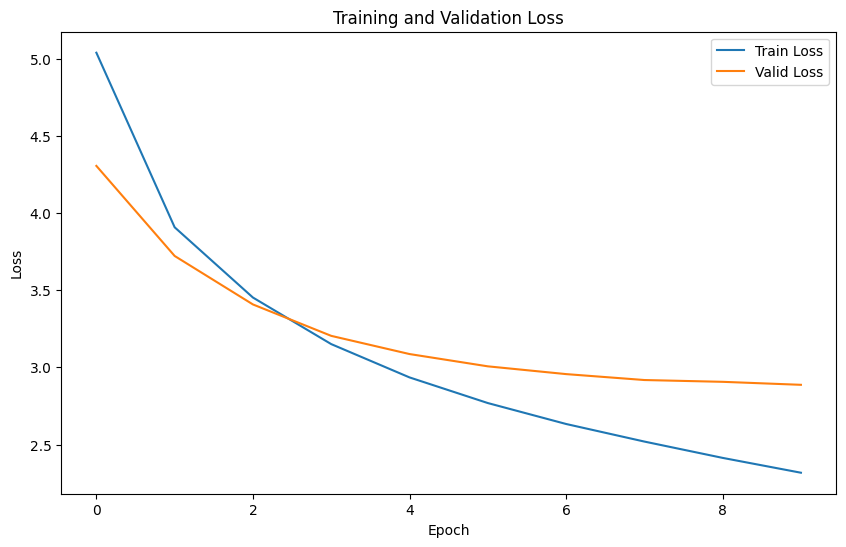

In [ ]:
batch_size = 64 # set as per recommendation
num_workers = 4
#learning_rate = 1e-3
#learning_rate = 1e-5
learning_rate = 5e-4
num_epochs = 10
pad_idx = vocab('<pad>')  # Usually 0
ckpt_path = "decoder_checkpoint.pth"

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

# define the loss function & optimizer
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.Adam(decoder_lstm.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []
best_valid_loss = float('inf')

for epoch in range(num_epochs):
    decoder_lstm.train()
    total_train_loss = 0
    total_train_words = 0
    
    for batch in train_loader:
        features, captions, lengths = batch
        features = features.to(device)       # features (batch_size,2048)
        captions = captions.to(device)       # (batch_size,47)
        
        # decoder's forward pass outputs (total_words, vocab_size)
        outputs = decoder_lstm(features.squeeze(1), captions, lengths)  
 
        # we incremented lengths inside the model so we do same increment here for consistency
        mod_lengths = [l+1 for l in lengths] 
        
        #  we must exclude the last padded steps, the model predicted sum(l+1) tokens total
        # pack_padded_sequence handles this if we use mod_lengths  
        # for unsorted sequences, we use `enforce_sorted = False`  
        packed_targets = pack_padded_sequence(captions, mod_lengths, batch_first=True, enforce_sorted=False)

        # packed_targets.data shape: (total_words,)
        targets = packed_targets.data

        # compute loss
        loss = criterion(outputs, targets)
        
        # PyTorch accumulates gradients in tensor.grad attributes  
        # if we don’t zero them out each iteration, they accumulate over several batchesleading to incorrect updates  
        optimizer.zero_grad()

        # backpropagation step where the loss tensor holds scalars computed from model's predictions
        # essentially traverses the computational graph and calculates sthe gradients of the loss
        loss.backward()

        # updates the parameters based on these gradients and the chosen optimization algorithm, 
        # in our case Adam
        optimizer.step()

        total_train_loss += loss.item() * targets.size(0)
        total_train_words += targets.size(0)
    
    avg_train_loss = total_train_loss / total_train_words
    train_losses.append(avg_train_loss)

    # validation step
    decoder_lstm.eval()
    total_valid_loss = 0
    total_valid_words = 0

    with torch.no_grad():
        for batch in valid_loader:
            features, captions, lengths = batch
            features = features.to(device)
            captions = captions.to(device)

            outputs = decoder_lstm(features.squeeze(1), captions, lengths)
            
            mod_lengths = [l+1 for l in lengths]
            packed_targets = pack_padded_sequence(captions, mod_lengths, batch_first=True, enforce_sorted=False)
            targets = packed_targets.data

            loss = criterion(outputs, targets)
            total_valid_loss += loss.item() * targets.size(0)
            total_valid_words += targets.size(0)

    avg_valid_loss = total_valid_loss / total_valid_words
    valid_losses.append(avg_valid_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}")

    # ave checkpoint, if validation improves
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        torch.save(decoder_lstm.state_dict(), ckpt_path)
        print("Saved best model checkpoint.")

# plot losses after training
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# code to load the best checkpoint later:
# decoder_lstm.load_state_dict(torch.load(ckpt_path))
# decoder_lstm.eval()

Although training loss is lower than validation loss, the gap is not drastically widening and both are decreasing, which is generally a good sign and indicates proper learning. Since validation loss is still albeit slowly improving at epoch 10, running more epochs didn't yield considerable gains.  

## 4 Generate predictions on test data 

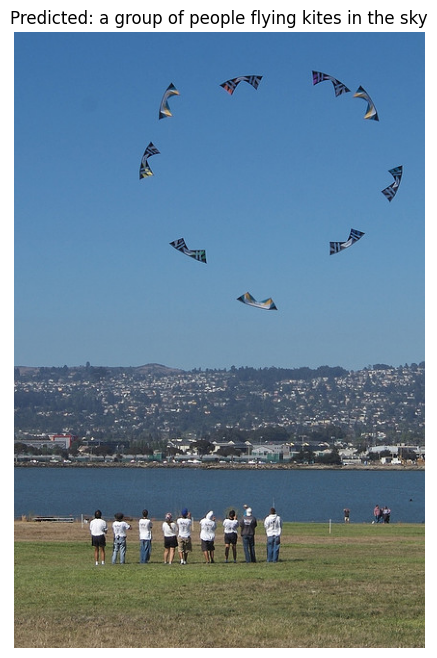

Reference Captions:
 - A group of people flying kites in a formation.
 - A group of people flying kites while standing in a field.
 - Nine people with kites in the sky forming a circle.
 - Several people on the grass near a waterfront flying kites in the sky.
 - Nine fliers participate as a group in a circular kite "ballet".




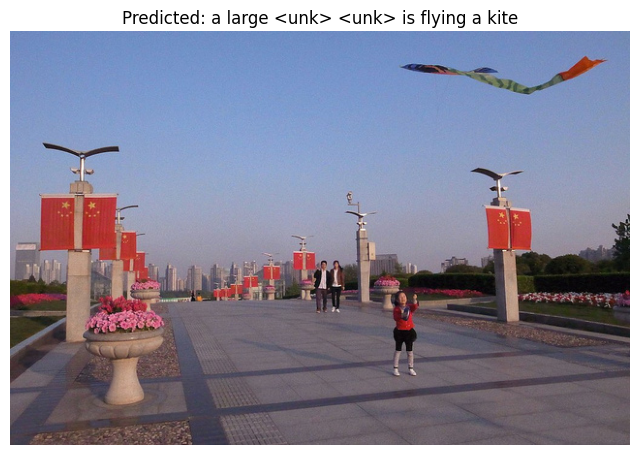

Reference Captions:
 - A woman flying a kite in an open courtyard.
 - A girl in China flying a kite during the day.
 - A woman standing on a road flying a colorful kite.
 - A person flying a kite near a view of a city.
 - Woman standing in the middle of the road with her arms in the air.




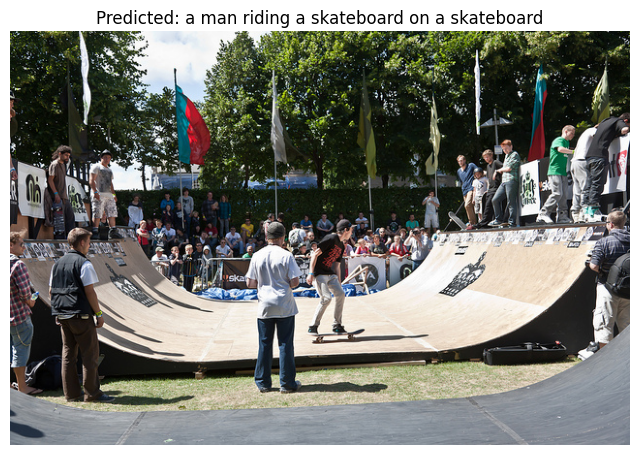

Reference Captions:
 - A group of people watching a man skateboard.
 - A crowd came to watch the boys skateboard. 
 - A group of people watching someone on a skateboard.
 - People watching a kid skateboard on a half-pipe.
 - Boys ride on skate boards as a crowd looks on.




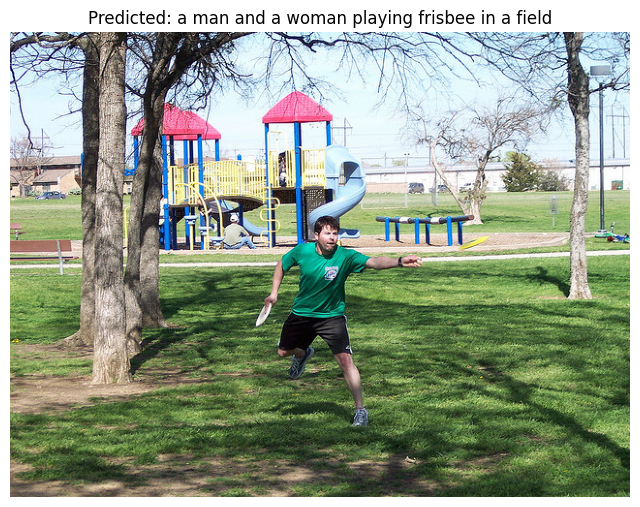

Reference Captions:
 - A man in a park playing Frisbee by a swing set. 
 - A man standing on top of a grass covered field.
 - a person that is holding a frizbee in a park
 - a person with two frisbees next to two trees 
 - A guy throwing a Frisbee with another one in his hand.




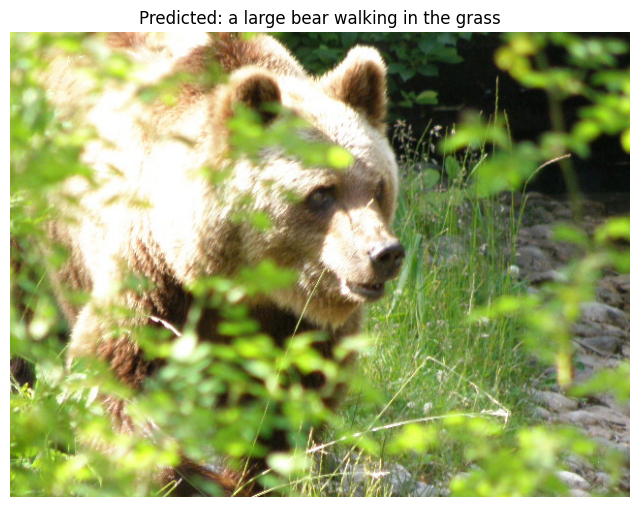

Reference Captions:
 - A bear is taking a walk through the forest. 
 - A grizzly bear walking in the woods looking off in the distance.
 - This is a picture of a zoo outdoor. 

 - a close up of a bear near bushes on a field 
 - a big brown bear walking in the grassy woods 




In [ ]:
def sample(decoder, features, vocab, max_length=47):
    """
    Generate a caption for given image features using a greedy search
    """
    decoder.eval()
    with torch.no_grad():
        # transform features and start decoding
        im_features = decoder.linear(features)
        im_features = decoder.bn(im_features)
        
        # initial LSTM state
        states = None

        # start token is the image feature itself
        # feed image features as the first input (like training), 
        # then subsequent steps will take the previous predicted word.
        inputs = im_features.unsqueeze(1)  # (1,1,embed_size)
        
        sampled_ids = []
        for _ in range(max_length):
            hiddens, states = decoder.rnn(inputs, states)  # hiddens: (1,1,hidden_size)
            outputs = decoder.fc(hiddens.squeeze(1))       # (1,vocab_size)
            _, predicted = outputs.max(dim=1)              # predicted: (1,)
            sampled_ids.append(predicted.item())
            
            if predicted.item() == vocab('<end>'):
                break
            
            # next input is the embedding of the predicted word
            inputs = decoder.embed(predicted).unsqueeze(1)
        
        # convert word IDs back to words
        sampled_caption = []
        for word_id in sampled_ids:
            word = vocab.idx2word[word_id]
            if word == '<end>':
                break
            sampled_caption.append(word)
        return sampled_caption

# hardcoded 5 random samples from the test dataset as asked
num_samples = 5
indices = random.sample(range(len(test_dataset)), num_samples)

decoder_lstm.eval()

for idx in indices:
    # get one sample from testset
    features, caption, length = test_dataset[idx]
    # features: (1,2048) or (2048,), ensure shape is correct
    # If shape is (1,2048), squeeze:
    if features.dim() == 3:
        features = features.squeeze(0)  # make it (2048,)
    
    features = features.unsqueeze(0).to(device)  # (1,2048)
    
    sampled_caption = sample(decoder_lstm, features, vocab)
        
    file_name = test_df.iloc[idx]['file_name']
    references = test_df[test_df['file_name'] == file_name]['caption'].tolist()

    img_path = os.path.join(images_dir, file_name)
    image = Image.open(img_path).convert('RGB')

    plt.figure(figsize=(8,8))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Predicted: " + " ".join(sampled_caption))
    plt.show()

    print("Reference Captions:")
    for ref_cap in references:
        print(" -", ref_cap)
    print("\n" + "="*50 + "\n")

## 5 Caption evaluation using BLEU score 

###  5.1 BLEU score

_One common way of comparing a generated text to a reference text is using BLEU. This article gives a good intuition to how the BLEU score is computed: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/, and you may find an implementation online to use. One option is the NLTK implementation `nltk.translate.bleu_score` here:_ https://www.nltk.org/api/nltk.translate.bleu_score.html

Average BLEU score on test set: 0.2021


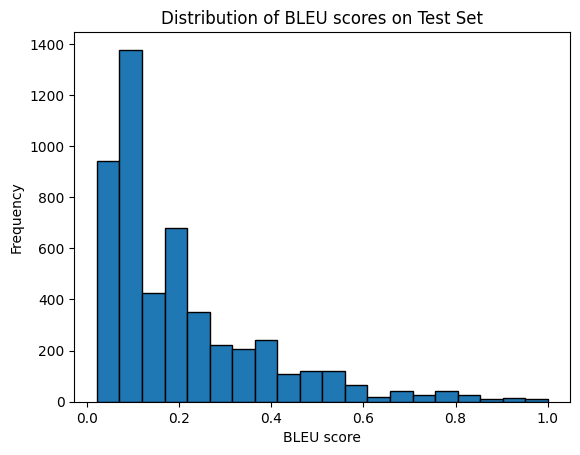

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

all_bleu_scores = []

# https://www.nltk.org/api/nltk.translate.bleu_score.html#nltk.translate.bleu_score.SmoothingFunction
chencherry = SmoothingFunction()

decoder_lstm.eval()

for i in range(len(test_dataset)):
    features, caption, length = test_dataset[i]  # features of shape (1,2048) or (2048,)
    if features.dim() == 3:
        features = features.squeeze(0)
    features = features.unsqueeze(0).to(device)

    predicted_caption = sample(decoder_lstm, features, vocab)
    
    # get reference captions for this image
    file_name = test_df.iloc[i]['file_name']

    # cleaned_caption is already lowercase and space-separated ... *
    references = test_df[test_df['file_name'] == file_name]['cleaned_caption'].tolist()
    
    # * ...so we can split directly
    references_tokenized = [ref.split() for ref in references]

    # compute BLEU-4. A typical weighting is equal for all n-grams
    # The weights for the BLEU-4 are 1/4 (25%) or 0.25 for each of the 1-gram, 2-gram, 3-gram and 4-gram scores.
    # references: 
    # . https://machinelearningmastery.com/calculate-bleu-score-for-text-python/
    # . https://www.nltk.org/api/nltk.translate.bleu_score.html
    # . https://www.nltk.org/howto/bleu.html

    score = sentence_bleu(references_tokenized, 
                          predicted_caption, 
                          weights=(0.25, 0.25, 0.25, 0.25),
                          smoothing_function=chencherry.method4)
                          #)*100
    
    all_bleu_scores.append(score)

average_bleu = sum(all_bleu_scores) / len(all_bleu_scores)
print(f"Average BLEU score on test set: {average_bleu:.4f}")

plt.hist(all_bleu_scores, bins=20, edgecolor='black')
plt.title('Distribution of BLEU scores on Test Set')
plt.xlabel('BLEU score')
plt.ylabel('Frequency')
plt.show()

The histogram plot shows that a majority of scores cluster between 0.0 and 0.3, with a tail extending up to 1.0, which indicates that eventhough some captions align well with references, many still differ from the reference wordings. The average BLEU score of ~0.20 therefore is representative of this observation, since BLEU heavily penalizes mismatches in n-gram overlaps.  

### 5.2 BLEU score examples

_Find one sample with high BLEU score and one with a low score, and display the model's predicted sentences, the BLEU scores, and the 5 reference captions._

In [ ]:
# max and min BLEU score indices
max_bleu_idx = max(range(len(all_bleu_scores)), key=lambda i: all_bleu_scores[i])
min_bleu_idx = min(range(len(all_bleu_scores)), key=lambda i: all_bleu_scores[i])

def display_sample_info(idx, title):
    features, caption, length = test_dataset[idx]
    
    # ensure features shape
    if features.dim() == 3:
        features = features.squeeze(0)
    features = features.unsqueeze(0).to(device)
    
    predicted_caption = sample(decoder_lstm, features, vocab)

    file_name = test_df.iloc[idx]['file_name']
    references = test_df[test_df['file_name'] == file_name]['cleaned_caption'].tolist()
    
    print(f"--- {title} ---")
    print(f"Index: {idx}, File Name: {file_name}")
    print(f"BLEU Score: {all_bleu_scores[idx]:.4f}")
    print("Predicted Caption:", " ".join(predicted_caption))
    print("Reference Captions:")
    for ref in references:
        print("-", ref)
    print()


display_sample_info(max_bleu_idx, "Sample with Highest BLEU Score")
display_sample_info(min_bleu_idx, "Sample with Lowest BLEU Score")

--- Sample with Highest BLEU Score ---
Index: 2717, File Name: 000000032906.jpg
BLEU Score: 1.0000
Predicted Caption: a group of people flying kites in the sky
Reference Captions:
- a group of people flying kites in a formation
- a group of people flying kites while standing in a field
- nine people with kites in the sky forming a circle
- several people on the grass near a waterfront flying kites in the sky
- nine fliers participate as a group in a circular kite ballet

--- Sample with Lowest BLEU Score ---
Index: 2332, File Name: 000000295201.jpg
BLEU Score: 0.0223
Predicted Caption: a <unk> <unk> <unk> <unk> <unk> <unk> <unk>
Reference Captions:
- a suit case filled with a magazine and a pair of shoes
- an open suitcase on the ground containing a pair of shoes and a magazine
- shoes and a magazine lie scattered inside an open suitcase
- an open suit case with a magazine and one show
- a suitcase containing only a pair of shoes and a magazine



## 6 Caption evaluation using cosine similarity 

###  6.1 Cosine similarity

_The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity._

Average cosine similarity on test set: 0.6713


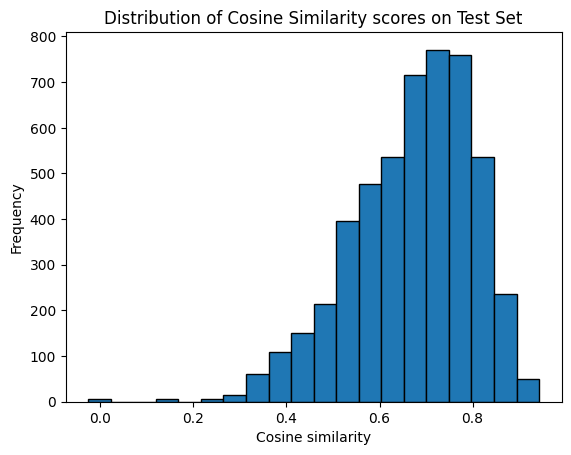

In [57]:
import torch.nn.functional as F

decoder_lstm.eval()

all_cos_scores = []

def caption_to_vector(caption_words, model, vocab):
    """
    Convert a list of words into an averaged embedding vector using the model's embedding layer.
    Args:
        caption_words (list[str]): tokenized caption words
        model: decoder model (containing an embed layer)
        vocab: vocabulary object mapping words to IDs
    Returns:
        torch.Tensor: averaged embedding vector of shape (embed_size,)
    """
    # convert words to indices
    word_ids = [vocab(w) for w in caption_words]
    word_ids_tensor = torch.tensor(word_ids, dtype=torch.long, device=device).unsqueeze(0)
    
    # get embeddings from model's embedding layer
    embeddings = model.embed(word_ids_tensor)  # shape (1, seq_len, embed_size)
    
    # avg across the sequence dimension
    avg_vector = embeddings.mean(dim=1).squeeze(0)  # shape (embed_size,)
    return avg_vector

with torch.no_grad():
    for i in range(len(test_dataset)):
        features, caption, length = test_dataset[i]
        if features.dim() == 3:
            features = features.squeeze(0)
        features = features.unsqueeze(0).to(device)

        # get predicted caption as a list of words
        predicted_caption = sample(decoder_lstm, features, vocab) 
        
        # get clean reference captions
        file_name = test_df.iloc[i]['file_name']
        references = test_df[test_df['file_name'] == file_name]['cleaned_caption'].tolist()
        references_tokenized = [ref.split() for ref in references]

        # Convert predicted caption to vector
        pred_vec = caption_to_vector(predicted_caption, decoder_lstm, vocab)

        # convert reference captions to vectors and compute cosine similarity
        similarities = []
        for ref in references_tokenized:
            ref_vec = caption_to_vector(ref, decoder_lstm, vocab)
            # compute cosine similarity 
            # cosine_similarity expects vectors to be 1D, hence unsqueeze
            # reference: https://pytorch.org/docs/stable/generated/torch.nn.functional.cosine_similarity.html
            sim = F.cosine_similarity(pred_vec.unsqueeze(0), ref_vec.unsqueeze(0)).item()
            similarities.append(sim)

        # avg similarity across all references for this image
        avg_cos_score = sum(similarities) / len(similarities)
        all_cos_scores.append(avg_cos_score)


average_cos = sum(all_cos_scores) / len(all_cos_scores)
print(f"Average cosine similarity on test set: {average_cos:.4f}")


plt.hist(all_cos_scores, bins=20, edgecolor='black')
plt.title('Distribution of Cosine Similarity scores on Test Set')
plt.xlabel('Cosine similarity')
plt.ylabel('Frequency')
plt.show()

#### 6.2 Cosine similarity examples

_Find one sample with high cosine similarity score and one with a low score, and display the model's predicted sentences, the cosine similarity scores, and the 5 reference captions._

In [58]:
# store indices for max and min cos similarity score
max_cos_idx = max(range(len(all_cos_scores)), key=lambda i: all_cos_scores[i])
min_cos_idx = min(range(len(all_cos_scores)), key=lambda i: all_cos_scores[i])

def display_cosine_example(idx, title):
    features, caption, length = test_dataset[idx]
    
    # ensure features var is the right shape and send it to gpu
    if features.dim() == 3:
        features = features.squeeze(0)
    features = features.unsqueeze(0).to(device)
    
    # generate predicted caption sample
    predicted_caption = sample(decoder_lstm, features, vocab)

    file_name = test_df.iloc[idx]['file_name']
    references = test_df[test_df['file_name'] == file_name]['cleaned_caption'].tolist()
    
    print(f"--- {title} ---")
    print(f"Index: {idx}, File Name: {file_name}")
    print(f"Cosine Similarity Score: {all_cos_scores[idx]:.4f}")
    print("Predicted Caption:", " ".join(predicted_caption))
    print("Reference Captions:")
    for ref in references:
        print("-", ref)
    print()

display_cosine_example(max_cos_idx, "Sample with Highest Cosine Similarity Score")
display_cosine_example(min_cos_idx, "Sample with Lowest Cosine Similarity Score")

--- Sample with Highest Cosine Similarity Score ---
Index: 2036, File Name: 000000033052.jpg
Cosine Similarity Score: 0.9429
Predicted Caption: a living room with a large couch and a tv
Reference Captions:
- a living room with a lot of chairs and a little bar in the corner
- a large living area with a fireplace and couches
- a living room has a large fireplace with decorative tiles
- a living room with a fireplace and sofas are featured
- a view of a living room area decorated with tiles and wood flooring

--- Sample with Lowest Cosine Similarity Score ---
Index: 2116, File Name: 000000041008.jpg
Cosine Similarity Score: -0.0262
Predicted Caption: a man holding a umbrella on the beach
Reference Captions:
- people are hidden under umbrellas as they make their way up an escalator
- people walking up outside stairs in raincoats under umbrellas
- a group of people climbing stairs with umbrellas
- many people going up some stairs with umbrellas
- several people walking up some steps while h

## 7 Comparing BLEU and Cosine similarity 

### 7.1 Test set distribution of scores

_Compare the model’s performance on the test set evaluated using BLEU and cosine similarity and discuss some weaknesses and strengths of each method (explain in words, in a text box below)._

_To compare the average test scores, we rescale the Cosine similarity scores [-1 to 1] to match the range of BLEU method [0.0 - 1.0]._

Average BLEU score on test set: 0.2021
Average Rescaled Cosine Similarity on test set: 0.8356


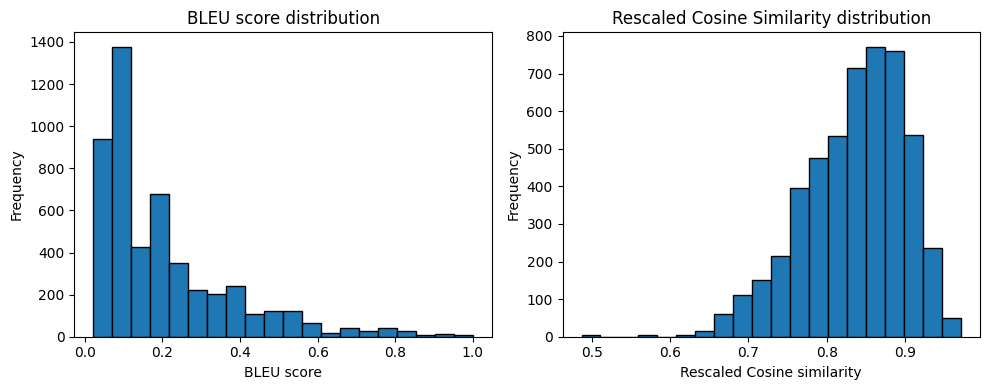

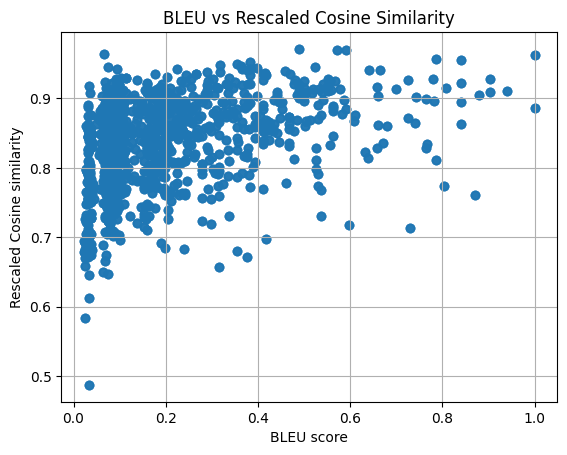

In [59]:
# rescale cos similarity from [-1,1] to [0,1]
all_cos_scores_rescaled = [(c + 1) / 2 for c in all_cos_scores]

# determine averages
avg_bleu = sum(all_bleu_scores) / len(all_bleu_scores)
avg_cos = sum(all_cos_scores_rescaled) / len(all_cos_scores_rescaled)

print(f"Average BLEU score on test set: {avg_bleu:.4f}")
print(f"Average Rescaled Cosine Similarity on test set: {avg_cos:.4f}")

# plots for comparison
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(all_bleu_scores, bins=20, edgecolor='black')
plt.title('BLEU score distribution')
plt.xlabel('BLEU score')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(all_cos_scores_rescaled, bins=20, edgecolor='black')
plt.title('Rescaled Cosine Similarity distribution')
plt.xlabel('Rescaled Cosine similarity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

plt.scatter(all_bleu_scores, all_cos_scores_rescaled, alpha=0.5)
plt.title('BLEU vs Rescaled Cosine Similarity')
plt.xlabel('BLEU score')
plt.ylabel('Rescaled Cosine similarity')
plt.grid(True)
plt.show()

A BLEU score of about 0.20 is relatively low, which means that on average the generated captions do not share many exact words or n-grams with the reference captions. While not zero, it indicates the model’s outputs differ considerably at a lexical level from the references provided.  

By contrast, a rescaled cosine similarity of around 0.84 suggests that even though the model’s captions might not match the reference captions word-for-word, the overall semantic content has similarities. 
To sum up, the model captures the essence of the scene but expresses it differently than what can be seen in reference captions.  

### 7.2 Analysis of individual examples

_Display one example where both methods give similar scores and another example where they do not, including both scores, predicted captions, and reference captions._

In [61]:
# already rescaled in previous cell
# all_cos_scores_rescaled = [(c + 1) / 2 for c in all_cos_scores]
bleu_array = np.array(all_bleu_scores)
cos_array = np.array(all_cos_scores_rescaled)

# store abs differences
score_diff = np.abs(bleu_array - cos_array)

# Idx where both methods are most similar
min_diff_idx = np.argmin(score_diff)

# Idx where both methods differ the most
max_diff_idx = np.argmax(score_diff)  

def display_example(idx, title):
    features, caption, length = test_dataset[idx]
    if features.dim() == 3:
        features = features.squeeze(0)
    features = features.unsqueeze(0).to(device)
    
    predicted_caption = sample(decoder_lstm, features, vocab)
    
    file_name = test_df.iloc[idx]['file_name']
    references = test_df[test_df['file_name'] == file_name]['cleaned_caption'].tolist()
    
    bleu = all_bleu_scores[idx]
    cos_rescaled = all_cos_scores_rescaled[idx]

    file_name = test_df.iloc[idx]['file_name']
    references = test_df[test_df['file_name'] == file_name]['caption'].tolist()

    img_path = os.path.join(images_dir, file_name)
    image = Image.open(img_path).convert('RGB')

    plt.figure(figsize=(8,8))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Predicted: " + " ".join(sampled_caption))
    plt.show()

    
    print(f"--- {title} ---")
    print(f"Index: {idx}, File Name: {file_name}")
    print(f"BLEU score: {bleu:.4f}, Rescaled Cosine Similarity: {cos_rescaled:.4f}")
    print("Predicted caption:", " ".join(predicted_caption))
    print("Reference captions:")
    for ref in references:
        print("-", ref)
    print()


display_example(min_diff_idx, "Example with similar BLEU and Cosine Similarity scores")
display_example(max_diff_idx, "Example with different BLEU and Cosine Similarity scores")

--- Example with Similar BLEU and Cosine Similarity Scores ---
Index: 1495, File Name: 000000532947.jpg
BLEU Score: 0.9036, Rescaled Cosine Similarity: 0.9098
Predicted Caption: a herd of sheep grazing on a lush green field
Reference Captions:
- a group of sheep on a grassy field
- a pasture of sheep grazing on the grass
- sheep are grazing on a pasture on a farm
- a herd of sheep grazing on a lush green hillside
- white sheep are grazing in a green pasture

--- Example with Different BLEU and Cosine Similarity Scores ---
Index: 905, File Name: 000000565312.jpg
BLEU Score: 0.0662, Rescaled Cosine Similarity: 0.9635
Predicted Caption: a woman in a black shirt and white shorts playing a tennis ball
Reference Captions:
- a little girl in a pink dress holding a tennis racquet
- a girl wearing a purple skirt holds out a tennis racket in a parking lot area
- a girl in a parking lot holding a racket
- a little girl in a lavender dress holding a tennis racquet
- a girl in a parking lot with a 

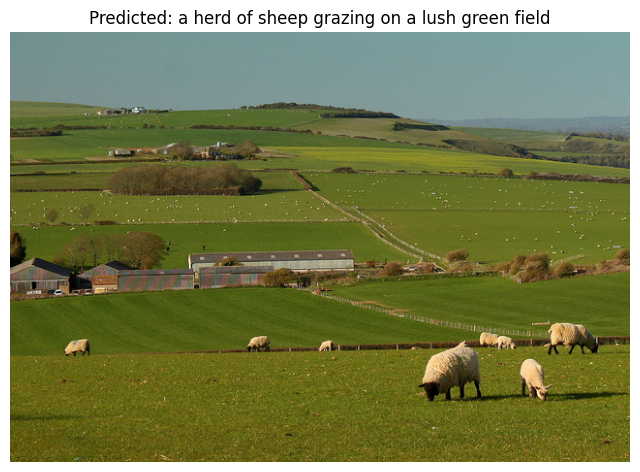

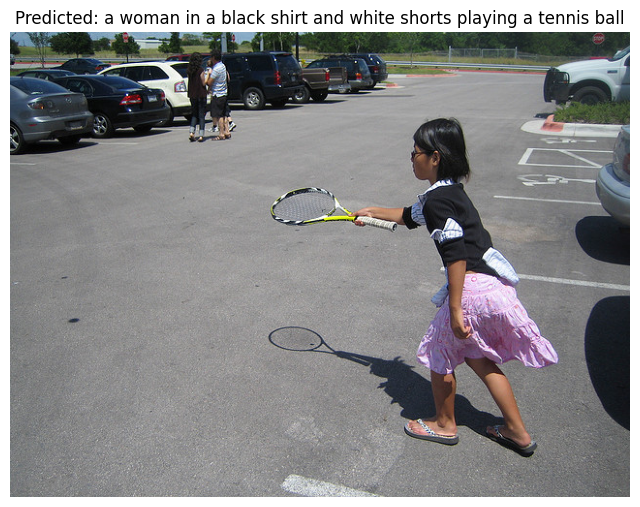

In [68]:
indices = [1495, 905]

decoder_lstm.eval()

for idx in indices:
    features, caption, length = test_dataset[idx]
    if features.dim() == 3:
        features = features.squeeze(0)
    features = features.unsqueeze(0).to(device)

    sampled_caption = sample(decoder_lstm, features, vocab)

    file_name = test_df.iloc[idx]['file_name']
    references = test_df[test_df['file_name'] == file_name]['caption'].tolist()

    img_path = os.path.join(images_dir, file_name)
    image = Image.open(img_path).convert('RGB')

    plt.figure(figsize=(8,8))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Predicted: " + " ".join(sampled_caption))
    plt.show()

At index 1495, both BLEU and cosine similarity are high. The predicted caption closely matches the reference captions both lexically ("a herd of sheep", "green field", "grazing") and semantically (sheep grazing in a green area). The strong n-gram overlap leads to a high BLEU score, while the overall semantic coherence outputs a high cosine similarity score, since both the model and reference captions "talk about" sheep, greenery, and grazing. 
Hence, the model closely matches the actual wording and both lexical and semantic metrics agree for this example.  

At the example index 905, BLEU is very low (0.0662) because the predicted caption uses different words than the references. The reference captions focus on "a little girl" in a "dress" or "skirt," holding a "tennis racquet" in a "parking lot." The predicted caption says "a woman in a black shirt and white shorts playing a tennis ball," which differs lexically since no exact n-gram matches for "dress," "parking lot," or "pink/purple/lavender".

## References

<ol>
  <li id="ref1">
    Tsung-Yi L., Michael M., Serge B., Lubomir B., Ross G., James H., Pietro P., 
    Perona D., Ramanan C. Lawrence, Zitnick P., "Microsoft COCO: Common Objects in Context", 
    2015, 
    <a href="https://arxiv.org/pdf/1405.0312" target="_blank">
      https://arxiv.org/pdf/1405.0312
    </a>
  </li>
  
  <li id="ref2">
    Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun, 
    “Deep Residual Learning for Image Recognition,” 
    IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2016, 
    <a href="https://arxiv.org/abs/1512.03385" target="_blank">
      https://arxiv.org/abs/1512.03385
    </a>
  </li>
  
  <li id="ref3">
    Vinyals, O., Toshev, A., Bengio, S. and Erhan, D. (2015) 
    ‘Show and Tell: A Neural Image Caption Generator’, 
    IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 
    Boston, MA, USA, 7–12 June. IEEE, pp. 3156–3164. 
    Available at: 
    <a href="https://doi.org/10.1109/CVPR.2015.7298935" target="_blank">
      https://doi.org/10.1109/CVPR.2015.7298935
    </a> 
    (Accessed: 20 December 2024).
  </li>
  
  <li id="ref4">
    Karpathy, A. and Fei-Fei, L. (2015) 
    ‘Deep visual-semantic alignments for generating image descriptions’, 
    IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 
    Boston, MA, USA, 7–12 June. IEEE, pp. 3128–3137. 
    Available at: 
    <a href="https://doi.org/10.1109/CVPR.2015.7298932" target="_blank">
      https://doi.org/10.1109/CVPR.2015.7298932
    </a> 
    (Accessed: 20 December 2024).
  </li>
  
  <li id="ref5">
    Xu, K., Ba, J., Kiros, R., et al. (2015) 
    ‘Show, Attend and Tell: Neural Image Caption Generation with Visual Attention’, 
    International Conference on Machine Learning (ICML), 
    Lille, France, 6–11 July. JMLR, pp. 2048–2057. 
    Available at: 
    <a href="http://proceedings.mlr.press/v37/xuc15.html" target="_blank">
      http://proceedings.mlr.press/v37/xuc15.html
    </a> 
    (Accessed: 20 December 2024).
  </li>
  
  <li id="ref6">
    Anderson, P., He, X., Buehler, C., et al. (2018) 
    ‘Bottom-Up and Top-Down Attention for Image Captioning and Visual Question Answering’, 
    IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 
    Salt Lake City, UT, USA, 18–23 June. IEEE, pp. 6077–6086. 
    Available at: 
    <a href="https://doi.org/10.1109/CVPR.2018.00636" target="_blank">
      https://doi.org/10.1109/CVPR.2018.00636
    </a> 
    (Accessed: 21 December 2024).
  </li>
  
  <li id="ref7">
    Ioffe, S. and Szegedy, C. (2015) 
    ‘Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift’, 
    International Conference on Machine Learning (ICML), 
    Lille, France, 6–11 July. JMLR, pp. 448–456. 
    Available at: 
    <a href="http://proceedings.mlr.press/v37/ioffe15.html" target="_blank">
      http://proceedings.mlr.press/v37/ioffe15.html
    </a> 
    (Accessed: 21 December 2024).
  </li>
  
  <li id="ref8">
    Pennington, J., Socher, R. and Manning, C.D. (2014) 
    ‘GloVe: Global Vectors for Word Representation’, 
    Conference on Empirical Methods in Natural Language Processing (EMNLP), 
    Doha, Qatar, 25–29 October. ACL, pp. 1532–1543. 
    Available at: 
    <a href="https://aclanthology.org/D14-1162/" target="_blank">
      https://aclanthology.org/D14-1162/
    </a> 
    (Accessed: 21 December 2024).
  </li>
  
  <li id="ref9">
    Goodfellow, I., Bengio, Y. and Courville, A. (2016) 
    Deep Learning. Cambridge, MA: MIT Press. 
    Available at: 
    <a href="http://www.deeplearningbook.org" target="_blank">
      http://www.deeplearningbook.org
    </a> 
    (Accessed: 21 December 2024).
  </li>
  
  <li id="ref10">
    Srivastava, N., Hinton, G., Krizhevsky, A., et al. (2014) 
    ‘Dropout: A Simple Way to Prevent Neural Networks from Overfitting’, 
    Journal of Machine Learning Research, 15(1), pp. 1929–1958. 
    Available at: 
    <a href="http://jmlr.org/papers/v15/srivastava14a.html" target="_blank">
      http://jmlr.org/papers/v15/srivastava14a.html
    </a> 
    (Accessed: 21 December 2024).
  </li>
  
  <li id="ref11">
    Kingma, D.P. and Ba, J. (2015) 
    ‘Adam: A Method for Stochastic Optimization’, 
    3rd International Conference on Learning Representations (ICLR), 
    San Diego, CA, USA, 7–9 May. 
    Available at: 
    <a href="https://arxiv.org/abs/1412.6980" target="_blank">
      https://arxiv.org/abs/1412.6980
    </a> 
    (Accessed: 21 December 2024).
  </li>
  
  <li id="ref12">
    Papineni, K., Roukos, S., Ward, T. and Zhu, W.-J. (2002) 
    ‘BLEU: A Method for Automatic Evaluation of Machine Translation’, 
    40th Annual Meeting of the Association for Computational Linguistics (ACL), 
    Philadelphia, PA, USA, 7–12 July. ACL, pp. 311–318.
  </li>
  
  <li id="ref13">
    Devlin, J., Cheng, H., Fang, H., et al. (2015) 
    ‘Language Models for Image Captioning: The Quirks and What Works’, 
    International Conference on Acoustics, Speech, and Signal Processing (ICASSP), 
    Brisbane, Australia, 19–24 April. IEEE, pp. 176–180.
  </li>
</ol>